In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import seaborn as sns
from IPython.display import clear_output
import matplotlib

plt.style.use(['plorts', 'plorts-print', 'buffer-workshop.mplstyle'])
width = 7.141
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
experiments = pd.read_sql("""
select id,
  num_flows,
  max_queue_depth_cells,
  max_queue_depth_packets,
  algorithm
from experiments
where note in ('underutilization')
and action = 'drop'
and algorithm in ('reno', 'bbr','cubic','scalable')
--and algorithm in ('cubic')
--and 5000 <= max_queue_depth_cells
--and max_queue_depth_cells <= 20000
""", con=con)
len(experiments)

505

In [4]:
k = 3

results = []

n_exp = len(experiments)
i = 0

for _,exp in experiments.iterrows():
    traces = pd.read_sql("""
        select experiment_id, timestamp_sec, queue_depth_cells, queue_depth_packets
        from postcard_traces
        where experiment_id='{}'
          and src_port != 22
          and dst_port != 22
    """.format(exp.id), con=con) 
    
    # Only consider middle (k-2)/k-th of the experiment duration for inefficiency
    ts_min = traces['timestamp_sec'].min()
    ts_max = traces['timestamp_sec'].max()
    ts_dif = ts_max - ts_min
    ts_min += ts_dif / k
    ts_max -= ts_dif / k
    ts_dur = ts_max - ts_min
    
    tr_df = traces[(traces.timestamp_sec > ts_min) & (traces.timestamp_sec < ts_max)]
    
    tr_df['queue_depth_packets_rd'] = np.ceil(tr_df['queue_depth_packets'])
    
    min_depth = tr_df.queue_depth_packets_rd.min()
    p01,p02,p05,p10,p50,p95,p99 = np.quantile(tr_df.queue_depth_packets_rd, [0.01, 0.02, 0.05, 0.1, 0.5, 0.95, 0.99])
    
    results.append([exp.id, exp.num_flows, exp.max_queue_depth_cells, exp.max_queue_depth_packets, exp.algorithm,
                    min_depth, p01, p02, p05, p10, p50, p95, p99])
    i += 1
    clear_output(wait=True)
    print("{}/{} completed.".format(i,n_exp))

results = pd.DataFrame(results, columns=['experiment_id', 'num_flows', 'max_queue_depth_cells', 'max_queue_depth_packets', 'algorithm',
                                         'min_depth', 'depth_p01', 'depth_p02', 'depth_p05', 'depth_p10', 'depth_p50', 'depth_p95', 'depth_p99'])

6/505 completed.


KeyboardInterrupt: 

In [ ]:
smaller_experiments = pd.read_sql("""
select id,
  num_flows,
  max_queue_depth_cells,
  max_queue_depth_packets,
  algorithm
from experiments
where note in ('postcard', 'postcard-ecn', 'postcard-20000', 'postcard-v-small')
and action = 'drop'
and algorithm in ('reno', 'bbr','cubic','scalable')
--and algorithm in ('cubic')
and max_queue_depth_cells < 5000
""", con=con)
len(smaller_experiments)

In [ ]:
k = 3

smaller_results = []

n_exp = len(smaller_experiments)
i = 0

for _,exp in smaller_experiments.iterrows():
    traces = pd.read_sql("""
        select experiment_id, timestamp_sec, queue_depth_cells, queue_depth_packets
        from postcard_traces
        where experiment_id='{}'
          and src_port != 22
          and dst_port != 22
    """.format(exp.id), con=con) 
    
    # Only consider middle (k-2)/k-th of the experiment duration for inefficiency
    ts_min = traces['timestamp_sec'].min()
    ts_max = traces['timestamp_sec'].max()
    ts_dif = ts_max - ts_min
    ts_min += ts_dif / k
    ts_max -= ts_dif / k
    ts_dur = ts_max - ts_min
    
    tr_df = traces[(traces.timestamp_sec > ts_min) & (traces.timestamp_sec < ts_max)]
    
    tr_df['queue_depth_packets_rd'] = np.ceil(tr_df['queue_depth_packets'])
    
    min_depth = tr_df.queue_depth_packets_rd.min()
    p01,p02,p05,p10,p50,p95,p99 = np.quantile(tr_df.queue_depth_packets_rd, [0.01, 0.02, 0.05, 0.1, 0.5, 0.95, 0.99])
    
    smaller_results.append([exp.id, exp.num_flows, exp.max_queue_depth_cells, exp.max_queue_depth_packets, exp.algorithm,
                    min_depth, p01, p02, p05, p10, p50, p95, p99])
    i += 1
    clear_output(wait=True)
    print("{}/{} completed.".format(i,n_exp))

smaller_results = pd.DataFrame(smaller_results, columns=['experiment_id', 'num_flows', 'max_queue_depth_cells', 'max_queue_depth_packets', 'algorithm',
                                         'min_depth', 'depth_p01', 'depth_p02', 'depth_p05', 'depth_p10', 'depth_p50', 'depth_p95', 'depth_p99'])

In [9]:
res = pd.concat([results])
res['formatted_algorithm'] = ['BBR' if a == 'bbr' else a.title() for a in res['algorithm']]
res.to_csv("generalized_test.csv")

In [5]:
res = pd.read_csv('generalized_test.csv')

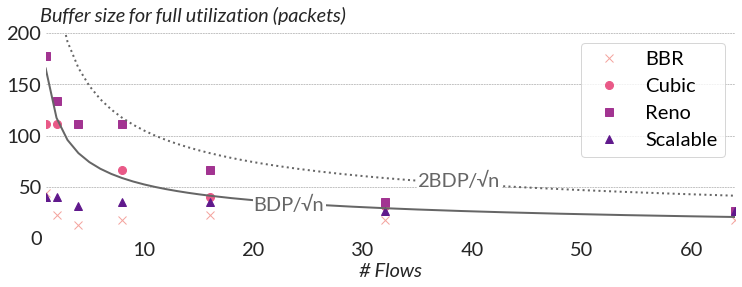

In [9]:
smallest_buffers = res[res.depth_p01 > 2].groupby(['formatted_algorithm', 'num_flows'], as_index=False).min()

plt.figure(figsize=(1.5*width, 0.4*1.5*width))
plorts.scatter(smallest_buffers, x="num_flows", y="max_queue_depth_packets", hue='formatted_algorithm',
               markersize=8, markers=['x', 'o', 's', '^'])

bdp = 166
ns = np.arange(1,131)
plt.plot(ns, bdp/np.sqrt(ns), color='#666666')
plt.text(20, bdp/np.sqrt(20)-10, 'BDP/√n', color='#666666', bbox=dict(facecolor='white', edgecolor='white', pad=1),
         fontname='sans')
plt.plot(ns, 2*bdp/np.sqrt(ns), color='#666666', linestyle=":")
plt.text(35, 0.9*2*bdp/np.sqrt(35), '2BDP/√n', color='#666666', bbox=dict(facecolor='white', edgecolor='white', pad=1),
        fontname='sans')

plt.xlabel("# Flows")
plt.ylabel("Buffer size for full utilization (packets)")
plorts.style_axis()
plt.legend(loc='upper right')
plt.axis(xmax=64, ymin=0, ymax=200)

plt.savefig("../figures/sqrt-n-rule-tested.png")